## Objectives

## Code Implementation

In [3]:
import pandas as pd
cities = pd.read_csv('../data/cleaned_data/apta_cities_cleaned.csv')
cities = cities.drop(columns=['Unnamed: 0'])
cities.head()

,City,Population,Area,Cost_per_trip,Fare_per_trip,Miles_per_trip
0,"Seattle--Tacoma, WA",3544011,982.52,13.906032,1.570667,5.786344
1,"Spokane, WA",447279,171.67,13.433827,0.988308,4.772569
2,"Yakima, WA",133145,55.77,19.720093,1.112531,5.179168
3,"Eugene, OR",270179,73.49,10.851494,2.753356,3.684118
4,"Portland, OR--WA",2104238,519.30,10.804361,1.025659,4.011388


In [27]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score

X = cities.drop(columns=['City']).to_numpy()

print('NUMERIC MEAN:\n',np.mean(X,axis=0))
print("X SHAPE",X.shape)
print("NUMERIC COV:")
print(np.cov(X.T))

from numpy import linalg as LA
w, v1 = LA.eig(np.cov(X.T))
print("\nCOV EIGENVALUES:",w)
print("COV EIGENVECTORS (across rows):")
print(v1.T)

NUMERIC MEAN:
 [7.63817374e+05 2.54954371e+02 1.62164796e+01 1.69764181e+00
 6.02033451e+00]
X SHAPE (286, 5)
NUMERIC COV:
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.[[ 3.00348049e+12  6.21976504e+08 -2.68509287e+06 -2.80714130e+05
  -3.74964286e+05]
 [ 6.21976504e+08  1.60662563e+05 -7.09356971e+02 -8.34065149e+01
  -1.18548286e+02]
 [-2.68509287e+06 -7.09356971e+02  1.12521769e+02  1.14344019e+01
   1.54309551e+01]
 [-2.80714130e+05 -8.34065149e+01  1.14344019e+01  1.07182685e+01
   6.17463373e+00]
 [-3.74964286e+05 -1.18548286e+02  1.54309551e+01  6.17463373e+00
   2.61947556e+01]]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advance

In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(X)
print('\nPCA')
print(pca.components_)


PCA
[[ 9.99999979e-01  2.07085246e-04 -8.93993769e-07 -9.34629441e-08
  -1.24843257e-07]
 [-2.07087147e-04  9.99987172e-01 -4.82944608e-03 -7.95476612e-04
  -1.28713329e-03]
 [-1.36812764e-07  5.03927972e-03  9.77725251e-01  1.15731143e-01
   1.75026404e-01]
 [-1.31093957e-07  4.57011124e-04 -1.99629231e-01  2.56090918e-01
   9.45814677e-01]
 [-2.27827260e-08  9.92273370e-05 -6.46388484e-02  9.59699490e-01
  -2.73493506e-01]]


[[-1.          1.00000918  0.15303548 -1.4026303  -0.18249064]
 [ 0.99999082 -1.         -1.0434488   0.57451233  0.07709173]
 [-6.5344325   0.95836039  1.          1.72493959  0.36930913]
 [-0.71294624  1.74060667 -0.57973045 -1.         -1.01468027]
 [-5.47973306 12.97155936 -2.7077587  -0.98553212 -1.        ]]


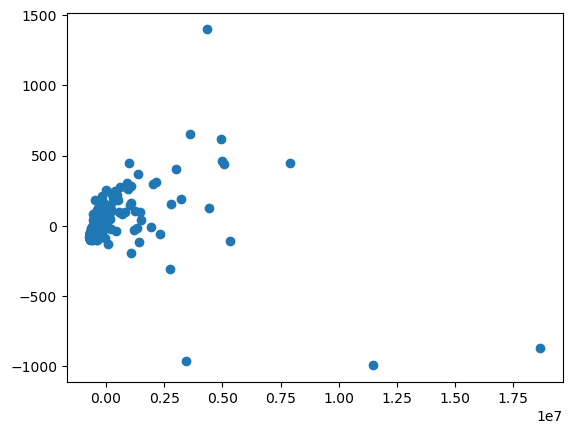

In [29]:
v2=pca.components_

print(v1/v2)
pca = PCA(n_components=5)
X1=pca.fit_transform(X)
plt.scatter(X1[:,0], X1[:,1])
plt.show()

RESULTS
shape :  (286, 2)
First few points : 
 [[ 13.150954   57.8999   ]
 [ 23.046926  -37.931778 ]
 [-45.15894     3.9606774]
 [ 64.51022   -35.225803 ]]


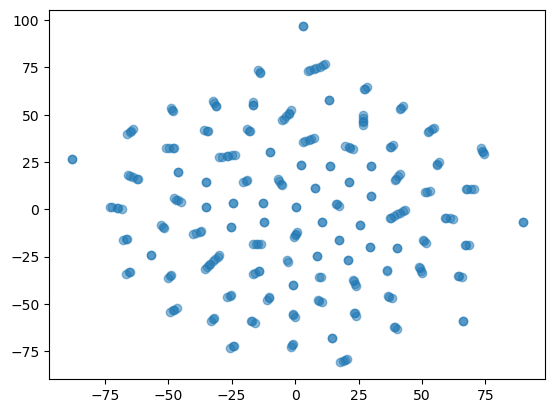

In [31]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=1).fit_transform(X)

# EXPLORE RESULTS
print("RESULTS") 
print("shape : ",X_embedded.shape)
print("First few points : \n",X_embedded[0:4,:])

# PLOT 
plt.scatter(X_embedded[:,0],X_embedded[:,1], alpha=0.5)
plt.show()

RESULTS
shape :  (286, 2)
First few points : 
 [[-42.433853    10.063747  ]
 [ -3.3064377   21.02925   ]
 [  0.53624296 -41.15471   ]
 [ 26.222113    13.95583   ]]


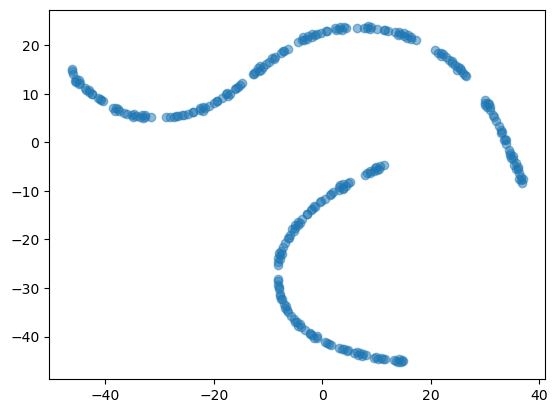

In [32]:
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=10).fit_transform(X)

# EXPLORE RESULTS
print("RESULTS") 
print("shape : ",X_embedded.shape)
print("First few points : \n",X_embedded[0:4,:])

# PLOT 
plt.scatter(X_embedded[:,0],X_embedded[:,1], alpha=0.5)
plt.show()

## Reporting